<header style="padding:1px;background:#f9f9f9;border-top:3px solid #00b2b1"><img id="Teradata-logo" src="https://www.teradata.com/Teradata/Images/Rebrand/Teradata_logo-two_color.png" alt="Teradata" width="220" align="right" />

<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>GLM Fraud Detection with Python and Vantage BYOM</b>
</header>

<p style = 'font-size:16px;font-family:Arial'>This notebook provides a demonstration "data science workflow" that illustrates how to leverage open source ML Pipelines with the power and scale of Teradata Vantage.  Users perform the large-scale operations such as feature analysis, data transformation, and ML Moodel Scoring in the Vantage environment without having to move data.</p>

<p style = 'font-size:16px;font-family:Arial'><b>Links:</b></p>
<ul style = 'font-size:16px;font-family:Arial'>
    <li>Uses a Data set and feature discovery methods outlined here: <a href = 'https://www.kaggle.com/georgepothur/4-financial-fraud-detection-xgboost/notebook'>https://www.kaggle.com/georgepothur/4-financial-fraud-detection-xgboost/notebook</a></li>
    <li>Python Package User Guide: <a href = 'https://docs.teradata.com/reader/eteIDCTX4O4IMvazRMypxQ/uDjppX7PJInABCckgu~KFg'>https://docs.teradata.com/reader/eteIDCTX4O4IMvazRMypxQ/uDjppX7PJInABCckgu~KFg</a></li>
    <li>Teradataml Python reference: <a href = 'https://docs.teradata.com/reader/GsM0pYRZl5Plqjdf9ixmdA/MzdO1q_t80M47qY5lyImOA'>https://docs.teradata.com/reader/GsM0pYRZl5Plqjdf9ixmdA/MzdO1q_t80M47qY5lyImOA</a></li>
</ul>


<p style = 'font-size:16px;font-family:Arial'><b>Contents</b></p>
<ol style = 'font-size:16px;font-family:Arial'>
    <li>Configuring the environment</li>
    <li>Initiate a connection to Vantage</li>
    <li>Read the data from Vantage as a teradaml Dataframe</li>
    <li>Perform discovery on the data and analyze features</li>
    <li>Clean up the dataset</li>
    <li>Create training and testing datasets in Vantage</li>
    <li>Create a PMML pipeline locally using sklearn and train it</li>
    <li>Load trained PMML Model into Vantage</li>
    <li>Score the model directly in Vantage</li>
    <li>Visualize the results (ROC curve and AUC)</li>
    <li>Cleanup</li>
</ol>    

<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>Experience</b></p>


<p style = 'font-size:16px;font-family:Arial'>This demo takes about 5 minutes to run.</p>

<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>Installing some dependencies</b>

In [31]:
!pip install sklearn2pmml --user
!pip install jdk4py --user

<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>1. Configuring the Environment</b>
<p style = 'font-size:16px;font-family:Arial'>In the section, we import the required libraries and set environment variables and environment paths (if required).</p>

In [32]:
# import statements
import os

import pandas as pd
import numpy as np
from jdk4py import JAVA, JAVA_HOME, JAVA_VERSION

from teradataml import *
from teradataml.options.display import display
# from teradataml.catalog.byom import *

import tdconnect


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn2pmml.pipeline import PMMLPipeline
from sklearn2pmml import sklearn2pmml

import getpass
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline 

In [33]:
# Set some environmental stuff - need java in the path if necessary

os.environ['PATH'] = os.environ['PATH'] + os.pathsep + str(JAVA_HOME)
os.environ['PATH'] = os.environ['PATH'] + os.pathsep + str(JAVA)[:-5]

In [34]:
# Location of the BYOM functions
configure.byom_install_location = 'TRNG_BYOM'

<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>2. Initiate a connection to Vantage</b>

<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>Make changes for your execution</b></p>

<p style = 'font-size:16px;font-family:Arial'>The Jupyter Module for Teradata provides a helper library called tdconnect - this can use the underlying client configs and pass a JWT token for SSO. Establish connection to Teradata Vantage server (uses the Teradata SQL Driver for Python). Before you execute the following statement, replace the variables &ltHOSTNAME&gt, &ltUID&gt and &ltPWD&gt with your target Vantage system hostname (or IP address), and your database user ID(QLID) and password, respectively.</p>
    
<p style = 'font-size:14px;font-family:Arial'>td_context = create_context(host="tdprdX.td.teradata.com", username="xy123456", password=gp.getpass(prompt='Password:'), logmech="LDAP")</p>

In [35]:
eng = tdconnect.create_context('Vantage-LIVE')
print(eng)

Engine(teradatasql://tdprd3.td.teradata.com/?LOGDATA=***&LOGMECH=***)


<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>3. Read the data from Vantage as a teradaml Dataframe</b>
<p style = 'font-size:16px;font-family:Arial'>The data from <a href = 'https://www.kaggle.com/code/georgepothur/4-financial-fraud-detection-xgboost/data'>https://www.kaggle.com/code/georgepothur/4-financial-fraud-detection-xgboost/data</a> is loaded in Vantage in a table named "ip_data". Check the data size and print sample rows. 600k rows and 11 columns.</p>

In [36]:
# Get data as a teradataml dataframe
ip_data = DataFrame('ip_data')

print(ip_data.shape)
ip_data.to_pandas(num_rows = 5).head()

(636262, 12)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
txn_id,,,,,,,,,,,
468585,41,CASH_IN,163694.45,C1361197605,21199161.21,21362855.66,C1973686570,357993.26,87641.63,0,0
579751,139,CASH_IN,95474.95,C67839316,982275.84,1077750.79,C2134358672,3312693.58,3217218.63,0,0
514041,39,PAYMENT,8457.53,C266794736,417.00,0.00,M1766211715,0.00,0.00,0,0
124473,9,PAYMENT,5741.25,C1182515744,23808.01,18066.76,M1636688116,0.00,0.00,0,0
298945,688,PAYMENT,19394.80,C134795087,0.00,0.00,M596477207,0.00,0.00,0,0


<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>In-database data manipulation</b></p>
<p style = 'font-size:16px;font-family:Arial'>Example of an in-database manipulation of data. Here we rename a misspelt column without moving the data out of Vantage. We are renaming <b>oldbalanceOrg</b> to <b>oldbalanceOrig</b></p>

In [37]:
new_data = ip_data.assign(oldbalanceOrig = ip_data.oldbalanceOrg).drop(['oldbalanceOrg'] , axis=1)

new_data.to_pandas(num_rows = 5).head()

,step,type,amount,nameOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,oldbalanceOrig
txn_id,,,,,,,,,,,
338903,235,CASH_IN,158145.85,C1835438574,160157.85,C1482385811,81620.63,0.00,0,0,2012.00
187223,143,PAYMENT,3335.12,C731534041,16678.88,M680055380,0.00,0.00,0,0,20014.00
67892,257,CASH_IN,200666.98,C1990624653,594467.82,C748517742,494293.38,293626.40,0,0,393800.84
309087,40,TRANSFER,495839.51,C1486191929,0.00,C1408655500,708822.37,1204661.87,0,0,0.00
204190,349,CASH_OUT,454882.20,C759764679,0.00,C1606940159,3108907.92,3563790.12,0,0,0.00


<p style = 'font-size:16px;font-family:Arial'><b>Data Fields</b></p>
<ol style = 'font-size:16px;font-family:Arial'>
    <li><b>txn_id:</b> transaction-id</li>
    <li><b>step:</b> maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (31 days simulation).</li>
    <li><b>type:</b> CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.</li>
    <li><b>amount:</b> amount of the transaction in local currency.</li>
    <li><b>nameOrig:</b> customer who started the transaction</li>
    <li><b>oldbalanceOrg:</b> initial balance before the transaction</li>
    <li><b>newbalanceOrig:</b> new balance after the transaction</li>
    <li><b>nameDest:</b> customer who is the recipient of the transaction</li>
    <li><b>oldbalanceDest:</b> initial balance recipient before the transaction.</li>
    <li><b>newbalanceDest:</b> new balance recipient after the transaction.</li>
    <li><b>isFraud:</b> This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.</li>
</ol>

<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>Check if any column has missing values</b></p>

In [38]:
new_data.info(null_counts = True)

<class 'teradataml.dataframe.dataframe.DataFrame'>
Data columns (total 12 columns):
step              636262 non-null int  
type              636262 non-null str  
amount            636262 non-null float
nameOrig          636262 non-null str  
newbalanceOrig    636262 non-null float
nameDest          636262 non-null str  
oldbalanceDest    636262 non-null float
newbalanceDest    636262 non-null float
isFraud           636262 non-null int  
isFlaggedFraud    636262 non-null int  
txn_id            636262 non-null int  
oldbalanceOrig    636262 non-null float
dtypes: int(4), str(3), float(5)


<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>4. Perform discovery on the data and analyze features</b>

<p style = 'font-size:16px;font-family:Arial'>The following section is an example of dataset analysis.  We're trying to see what features are most impactful and can be used to train our model. We also want to minimize the amount of data transferred to the client, and maximize the amount of work done on the cluster.</p>
<br>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>6 Million records -> 8,213 records -> 20/40 records.<br>Feel free to skip down to the next section for analysis and next steps</b></p>

<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>4.1 Statitics of the dataset</b></p>

In [39]:
new_data.describe(include = "all")

func,step,type,amount,nameOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,txn_id,oldbalanceOrig
25%,156,None,13428.65,None,0,None,0,0,0,0,159065.25,0
75%,335,None,208834.273,None,144082.96,None,948507.353,1117308.023,0,0,477195.75,107369
count,636262,636262,636262,636262,636262,636262,636262,636262,636262,636262,636262,636262
mean,243.49,None,180563.336,None,849778.411,None,1101799.054,1227955.599,.001,0,318130.5,828668.689
max,742,None,92445516.64,None,38259597.25,None,355185537.1,355553416.3,1,1,636261,44892193.09


<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>4.2 How many fraudulent transactions do we have in our dataset?</b></p>

In [40]:
print(new_data.loc[new_data.isFraud == 1].shape[0])

861


<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>4.3 How many fraudulent transactions do we have group by transaction type?</b></p>

In [41]:
new_data.loc[new_data.isFraud == 1].groupby('type').count().get(['type','count_step']).sort('count_step', ascending = False)

type,count_step
TRANSFER,438
CASH_OUT,423


<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>4.4 Are there any patterns in amount of transaction?</b></p>

<p style = 'font-size:16px;font-family:Arial'>We see many transactions with amounts 10000000.0 and 0.0 as old balance in origin account. This might be and indication of attempted fraud.</p>

In [42]:
display.max_rows = 5
new_data.loc[new_data.isFraud == 1].groupby('oldbalanceOrig').count().get(['oldbalanceOrig','count_step']).sort('count_step', ascending = False)

oldbalanceOrig,count_step
10000000.0,14
0.0,4
828720.89,2
11630.38,2
805319.81,2


<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>4.5 What percentage of fraudulent transactions do we have where transaction amount is equal to old balance in the origin account?</b></p>

<p style = 'font-size:16px;font-family:Arial'>This might be the case where the fraudster emptied the account of the victim.</p>

In [43]:
t = new_data.loc[(new_data.isFraud == 1) and (new_data.amount == new_data.oldbalanceOrig)].shape[0] / new_data.loc[new_data.isFraud == 1].shape[0] * 100
print(str(round(t, 2)) + "%")

97.44%


<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>4.6 What percentage of fraudulent transactions do we have where new balance in the origin account is zero?</b></p>

<p style = 'font-size:16px;font-family:Arial'>This might be the case where the fraudster emptied the account of the victim.</p>

In [44]:
t = new_data.loc[new_data.isFraud == 1][new_data.newbalanceOrig == 0].shape[0] / new_data.loc[new_data.isFraud == 1].shape[0] * 100
print(str(round(t, 2)) + "%")

97.56%


<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>4.7 What percentage of fraudulent transactions do we have where old balance in the destination account is zero?</b></p>

<p style = 'font-size:16px;font-family:Arial'>This might be the case where the fraudster regularly makes fraud transaction and withdraws entire amount from the destiantion account.</p>

In [45]:
t = new_data.loc[new_data.isFraud == 1][new_data.oldbalanceDest == 0].shape[0] / new_data.loc[new_data.isFraud == 1].shape[0] * 100
print(str(round(t, 2)) + "%")

65.16%


<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>4.8 has this been "flagged" as fraud using prior predictive methods?</b></p>

In [46]:
new_data.loc[ip_data.isFraud == 1].groupby('isFlaggedFraud').count().get(['isFlaggedFraud','count_step']).sort('count_step', ascending = False)

isFlaggedFraud,count_step
0,859
1,2


<hr> 
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>4.9 Feature Analysis</b></p>
<p style = 'font-size:16px;font-family:Arial'>By analyzing the dataset, we come to the following conclusions about the features:</p>

<ol style = 'font-size:16px;font-family:Arial'>
    <li><b>step</b> : Include this feature. The fraudulent transactions distributed in many 'step' values.</li>
    <li><b>type</b> : Include this feature. The fraudulent transaction happened only in 'CASH_OUT' and 'TRANSFER' transaction types. So we will include only the records with type as 'CASH_OUT' and 'TRANSFER.'</li>
    <li><b>amount</b> : Include this feature. Though it won't explain all fraudulent transactions, amount as 10000000.0 and 0.0 denotes a high chance of fraud.</li>
    <li><b>nameOrig</b> : Drop this feature. There is no useful information from this column.</li>
    <li><b>oldbalanceOrig</b> : Include this feature. You could see that in almost all fraudulent transactions, 'oldbalanceOrig' and 'amount' has the same value. This is a strong indicator of a fraudulent transaction.</li>
    <li><b>newbalanceOrig</b> : Include this feature. For most of the fraudulent transactions, 'newbalanceOrig' = 0 (this fact supports our finding in #5)</li>
    <li><b>nameDest</b> : Drop this feature. There is no useful information from this column.</li>
    <li><b>oldbalanceDest</b> : Include this feature. Value of 'oldbalanceDest' is zero for nearly half of the fraudulent transaction.</li>
    <li><b>newbalanceDest</b> : Include this feature. Value of 'newbalanceDest' is zero for more than half of the fraudulent transaction. We will include this feature in our model.</li>
    <li><b>isFlaggedFraud</b> : Drop this feature. Only 2 transactions flagged correctly, so we can drop this.</li>    
</ol>

<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>5. Clean up the dataset</b>
<p style = 'font-size:16px;font-family:Arial'>Based on what we discovered above, we will:</p>
<ol style = 'font-size:16px;font-family:Arial'>
    <li>Remove all data that isn't 'CASH OUT' or 'TRANSFER'</li>
    <li>Drop "nameOrig" and "nameDest" since the origin and destination accounts don't matter.</li>
    <li>Drop "isFlaggedFraud" because that's a useless indicator as well</li>
</ol> 

In [47]:
clean_data = new_data.loc[(new_data.type == 'CASH_OUT') | (new_data.type == 'TRANSFER')]
clean_data.shape

(277253, 12)

In [48]:
clean_data = clean_data.drop(['nameDest', 'nameOrig', 'isFlaggedFraud'], axis = 1)

In [49]:
clean_data.head()

step,type,amount,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,txn_id,oldbalanceOrig
281,CASH_OUT,197171.59,0.0,397656.96,594828.55,0,4,0.0
39,CASH_OUT,3658.95,0.0,1011338.73,1014997.69,0,8,0.0
298,CASH_OUT,20254.52,9539.48,345444.91,365699.43,0,11,29794.0
371,CASH_OUT,192243.72,0.0,0.0,192243.72,0,14,5107.0
250,CASH_OUT,170600.69,0.0,208298.46,378899.15,0,17,130885.99
41,CASH_OUT,41733.49,0.0,166433.55,208167.04,0,18,0.0
544,CASH_OUT,243965.08,0.0,555896.7,799861.78,0,15,198541.0
130,CASH_OUT,1382.36,0.0,99275.94,100658.29,0,7,0.0
380,CASH_OUT,124490.28,0.0,205868.9,330359.18,0,3,103679.0
209,CASH_OUT,45902.16,0.0,1995692.55,2041594.71,0,2,341.0


<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>6. Create training and testing datasets in Vantage</b>

<p style = 'font-size:16px;font-family:Arial'>Here we'll copy this teradata Dataframe to a separate table in Vantage. We'll also create two datasets for training and testing in the ratio of 80:20.</p>

In [50]:
#create the source data table in the database
clean_data.to_sql('clean_data', if_exists = 'replace', primary_index='txn_id')

In [51]:
#lets do it in sql - drop TRAIN table if exists

qry = 'DROP TABLE clean_data_train;'
# Execute Query

try:
    eng.execute(qry)
except Exception as e:
    if str(e.args).find('3807') >= 1:
        pass
    else:
        raise

In [52]:
#Create TRAIN table using SAMPLE

qry = '''
CREATE MULTISET TABLE clean_data_train 
  AS(SELECT * FROM clean_data SAMPLE 0.8) 
WITH DATA
PRIMARY INDEX (txn_id);
'''

# Execute Query
eng.execute(qry)

In [53]:
#lets do it in sql - drop TEST table if exists

qry = 'DROP TABLE clean_data_test;'
# Execute Query
try:
    eng.execute(qry)
except Exception as e:
    if str(e.args).find('3807') >= 1:
        pass
    else:
        raise

In [54]:
#Create TEST table using SAMPLE

qry = '''
CREATE MULTISET TABLE clean_data_test
  AS(SELECT * FROM clean_data
    EXCEPT
    SELECT * FROM clean_data_train)
WITH DATA
PRIMARY INDEX (txn_id);  
'''

# Execute Query
eng.execute(qry)

<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>7. Create a PMML pipeline locally using sklearn and train it</b>
<p style = 'font-size:16px;font-family:Arial'>Here we will use Logistic Regression as a classifier model in our PMML pipeline. The Predictive Model Markup Language (PMML) is an XML-based language which provides a way for applications to define machine learning, statistical and data mining models and to share models between PMML compliant applications.</p>

In [55]:
# creating TD dataframes for training and testing datasets
clean_data_train = DataFrame('clean_data_train')
clean_data_test = DataFrame('clean_data_test')

<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>7.1 Create a local pandas dataframe.<b></p>
<p style = 'font-size:16px;font-family:Arial'>This dataframe is created outside Vantage. The model is trained outside Vantage. The model would be later saved to Vantage and in-database scoring would be performed at scale.</p>

In [56]:
clean_data_train_df = clean_data_train.to_pandas(all_rows = True)
clean_data_train_df.reset_index(inplace = True)

<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>7.2 Train the Pipeline and save the model locally<b></p>
<p style = 'font-size:16px;font-family:Arial'>The model would be saved in a file called <b>mm_fraud_glm_model.pmml</b></p>

In [57]:
y_train = clean_data_train_df[['isFraud']].astype(int)
X_train = clean_data_train_df[['step','amount','newbalanceOrig','oldbalanceDest','newbalanceDest','oldbalanceOrig']].astype(float)


pipeline = PMMLPipeline([
     ("classifier", LogisticRegression())
     ])
pipeline.fit(X_train, y_train)

sklearn2pmml(pipeline, "mm_fraud_glm_model.pmml", with_repr = True)

<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>8. Load trained PMML Model into Vantage</b>
<p style = 'font-size:16px;font-family:Arial'>Pass the local pmml file to the save_byom function. This function would load the <b>mm_fraud_glm_model.pmml</b> file into Vantage in a table called <b>mm_glm</b>. If there is alredy a model with same name, the previous on e would be deleted and new one would be loaded.</p>

In [58]:
# Load the PMML file into Vantage
try:
    res = save_byom(model_id = 'mm_glm1', model_file = 'mm_fraud_glm_model.pmml', table_name = 'mm_glm')

except Exception as e:
    # if our model exists, delete and rewrite
    if str(e.args).find('TDML_2200') >= 1:
        res = delete_byom(model_id = 'mm_glm1', table_name = 'mm_glm')
        res = save_byom(model_id = 'mm_glm1', model_file = 'mm_fraud_glm_model.pmml', table_name = 'mm_glm')
        pass
    else:
        raise

# Obtain a pointer to the model
model_tdf = DataFrame.from_query("SELECT * FROM mm_glm WHERE model_id = 'mm_glm1'")

Model is deleted.
Model is saved.


<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>9. Score the model directly in Vantage</b>

<p style = 'font-size:16px;font-family:Arial'> PMMLPredict will score the model on data resident in Vantage without moving data.</p>

In [59]:
# Run the PMMLPredict function in Vantage
result = PMMLPredict(
            modeldata = model_tdf,
            newdata = clean_data_test,
            accumulate = ['step','amount','newbalanceOrig','oldbalanceDest','newbalanceDest','oldbalanceOrig', 'isFraud'],
            overwrite_cached_models = '*',
            model_output_fields = ['probability(1)', 'probability(0)']
            )

In [60]:
# Create a local pandas dataframe of the results
result_df = result.result.to_pandas(all_rows = True)
result_df.head()

,step,amount,newbalanceOrig,oldbalanceDest,newbalanceDest,oldbalanceOrig,isFraud,prediction,probability(1),probability(0)
0,396,159663.41,0.0,0.00,159663.41,1228.0,0,,1.584356e-09,1.000000
1,235,41520.67,0.0,465224.15,506744.82,0.0,0,,4.632687e-04,0.999537
2,370,42375.88,0.0,2516262.62,2558638.50,0.0,0,,1.607240e-06,0.999998
3,162,435796.25,0.0,616998.04,1052794.29,58655.0,0,,2.003128e-18,1.000000
4,374,305153.08,0.0,489074.46,794227.54,0.0,0,,2.941319e-16,1.000000


<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>10. Visualize the results (ROC curve and AUC)</b>
<p style = 'font-size:16px;font-family:Arial'>Calculate mean absolute error and AUC(Area Under the Curve) for Receiver Operating Characteritic Curve</p>
<p style = 'font-size:16px;font-family:Arial'>Mean Absolute Error is the summation of difference of actual and predicted value averaged over the number of observations.</p>

In [61]:
print(mean_absolute_error(result_df['isFraud'], result_df['probability(1)']))

0.009164109022480268


<p style = 'font-size:16px;font-family:Arial'>ROC curve is a graph between TPR(True Positive Rate) and FPR(False Positive Rate). The area under the ROC curve is a metric on how good the model is able to distinguish between positive and negative classes. The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes. AUC above 0.75 is generally considered decent.</p>

In [62]:
AUC = roc_auc_score(result_df['isFraud'], result_df['probability(1)'])
AUC

0.9426413014102651

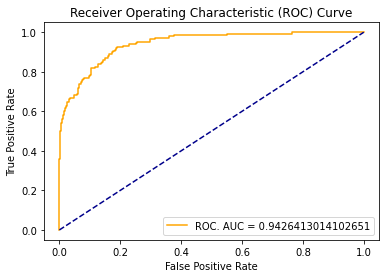

In [63]:
fpr, tpr, thresholds = roc_curve(result_df['isFraud'], result_df['probability(1)'])
plt.plot(fpr, tpr, color='orange', label='ROC. AUC = {}'.format(str(AUC)))
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>11. Cleanup</b>

In [64]:
eng.execute('DROP TABLE clean_data_train;')

In [65]:
eng.execute('DROP TABLE clean_data_test;')

In [66]:
eng.execute('DROP TABLE mm_glm;')

In [67]:
remove_context()

True

<footer style="padding:10px;background:#f9f9f9;border-bottom:3px solid #394851">©2022 Teradata. All Rights Reserved</footer>